Blood-Glucose Prediction using LSTM-CNN on the OhioT1DM dataset.

Article:
https://pmc.ncbi.nlm.nih.gov/articles/PMC7881904/

Dataset:
https://www.kaggle.com/datasets/ryanmouton/ohiot1dm?resource=download

In [1]:
import os
import xml.etree.ElementTree as ET
import pandas as pd
from datetime import datetime
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import zipfile
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, LSTM, Dense, Flatten, Dropout
from tensorflow.keras.regularizers import l2
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score


In [ ]:
import zipfile
import os

# Define the path for the uploaded zip file and the extraction directory
zip_path = '/content/data.zip'  # Replace with the path to your zip file
extraction_dir = '/content/extracted_data'

# Extract all files
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extraction_dir)

# List extracted files to verify
extracted_files = os.listdir(extraction_dir)
print("Extracted Files:", extracted_files)



Extracted Files: ['559-ws-testing.xml', '563-ws-training.xml', '591-ws-testing.xml', '591-ws-training.xml', '570-ws-training.xml', '559-ws-training.xml', '563-ws-testing.xml', '575-ws-training.xml', '575-ws-testing.xml', '570-ws-testing.xml', '588-ws-training.xml', '588-ws-testing.xml']


In [ ]:
import xml.etree.ElementTree as ET
import pandas as pd
from datetime import datetime

def parse_xml(file_path):
    """Parse XML file and return a DataFrame of timestamps and glucose levels."""
    tree = ET.parse(file_path)
    root = tree.getroot()
    data = []
    for event in root.find("glucose_level").findall("event"):
        ts = event.get("ts")
        value = float(event.get("value"))
        timestamp = datetime.strptime(ts, "%d-%m-%Y %H:%M:%S")
        data.append({"timestamp": timestamp, "glucose_level": value})
    return pd.DataFrame(data)

def load_patient_data(patient_id, directory):
    """Load both training and testing data for a specific patient."""
    train_file = os.path.join(directory, f"{patient_id}-ws-training.xml")
    test_file = os.path.join(directory, f"{patient_id}-ws-testing.xml")

    train_data = parse_xml(train_file)
    test_data = parse_xml(test_file)

    return train_data, test_data

# Define patient IDs and load data for each from the extracted directory
patient_ids = [559, 563, 570, 575, 588, 591]
all_data = {pid: load_patient_data(pid, extraction_dir) for pid in patient_ids}


In [ ]:
from sklearn.preprocessing import MinMaxScaler

def preprocess_data(data, sequence_length=30):
    """Normalize data and prepare it in sequences for the LSTM-CNN model."""
    scaler = MinMaxScaler()
    data['glucose_level'] = scaler.fit_transform(data[['glucose_level']])

    sequences = []
    labels = []
    for i in range(len(data) - sequence_length):
        seq = data['glucose_level'].values[i:i+sequence_length]
        label = data['glucose_level'].values[i + sequence_length]
        sequences.append(seq)
        labels.append(label)
    return np.array(sequences), np.array(labels), scaler

# Preprocess train and test data for a specific patient, e.g., patient ID 559
train_sequences, train_labels, scaler = preprocess_data(all_data[559][0])
test_sequences, test_labels, _ = preprocess_data(all_data[559][1])

# Reshape data to (samples, timesteps, features) for LSTM
train_sequences = train_sequences[..., np.newaxis]
test_sequences = test_sequences[..., np.newaxis]


In [ ]:
def create_lstm_cnn_model(input_shape, l2_lambda=0.001):
    model = Sequential([
        Conv1D(filters=32, kernel_size=3, activation='relu',
               kernel_regularizer=l2(l2_lambda), input_shape=input_shape),
        Conv1D(filters=64, kernel_size=3, activation='relu', kernel_regularizer=l2(l2_lambda)),
        LSTM(50, return_sequences=False, kernel_regularizer=l2(l2_lambda)),
        Dropout(0.2),
        Dense(50, activation='relu', kernel_regularizer=l2(l2_lambda)),
        Dense(1)  # Output layer for regression
    ])
    model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])
    return model

# Initialize model with input shape
input_shape = (train_sequences.shape[1], train_sequences.shape[2])
model = create_lstm_cnn_model(input_shape)
model.summary()

# Train the model
history = model.fit(train_sequences, train_labels, epochs=20, batch_size=32,
                    validation_data=(test_sequences, test_labels))


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                      │ (None, 28, 32)              │             128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_1 (Conv1D)                    │ (None, 26, 64)              │           6,208 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ (None, 50)                  │          23,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 50)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 50)                  │           2,550 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 31,937 (124.75 KB)

 Trainable params: 31,937 (124.75 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
337/337 ━━━━━━━━━━━━━━━━━━━━ 12s 23ms/step - loss: 0.1078 - mae: 0.0855 - val_loss: 0.0150 - val_mae: 0.0333
Epoch 2/20
337/337 ━━━━━━━━━━━━━━━━━━━━ 7s 19ms/step - loss: 0.0132 - mae: 0.0389 - val_loss: 0.0064 - val_mae: 0.0240
Epoch 3/20
337/337 ━━━━━━━━━━━━━━━━━━━━ 7s 21ms/step - loss: 0.0070 - mae: 0.0349 - val_loss: 0.0050 - val_mae: 0.0282
Epoch 4/20
337/337 ━━━━━━━━━━━━━━━━━━━━ 11s 24ms/step - loss: 0.0060 - mae: 0.0341 - val_loss: 0.0041 - val_mae: 0.0223
Epoch 5/20
337/337 ━━━━━━━━━━━━━━━━━━━━ 9s 22ms/step - loss: 0.0051 - mae: 0.0329 - val_loss: 0.0039 - val_mae: 0.0228
Epoch 6/20
337/337 ━━━━━━━━━━━━━━━━━━━━ 7s 21ms/step - loss: 0.0046 - mae: 0.0305 - val_loss: 0.0036 - val_mae: 0.0225
Epoch 7/20
337/337 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step - loss: 0.0046 - mae: 0.0306 - val_loss: 0.0033 - val_mae: 0.0214
Epoch 8/20
337/337 ━━━━━━━━━━━━━━━━━━━━ 7s 21ms/step - loss: 0.0039 - mae: 0.0274 - val_loss: 0.0030 - val_mae: 0.0175
Epoch 9/20
337/337 ━━━━━━━━━━━━━━━━━━━━ 6s 18m

In [ ]:
def evaluate_model(model, X, y, dataset_type="Train"):
    """Evaluate the model on the given dataset and print metrics."""
    predictions = model.predict(X)
    mse = mean_squared_error(y, predictions)
    mae = mean_absolute_error(y, predictions)
    r2 = r2_score(y, predictions)

    print(f"{dataset_type} MSE: {mse:.4f}")
    print(f"{dataset_type} MAE: {mae:.4f}")
    print(f"{dataset_type} R2 Score: {r2:.4f}")
    return mse, mae, r2

# Evaluate on train and test sets
print("Evaluating Train Data")
train_mse, train_mae, train_r2 = evaluate_model(model, train_sequences, train_labels, "Train")

print("\nEvaluating Test Data")
test_mse, test_mae, test_r2 = evaluate_model(model, test_sequences, test_labels, "Test")


Evaluating Train Data
337/337 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step
Train MSE: 0.0013
Train MAE: 0.0238
Train R2 Score: 0.9650

Evaluating Test Data
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
Test MSE: 0.0010
Test MAE: 0.0220
Test R2 Score: 0.9711


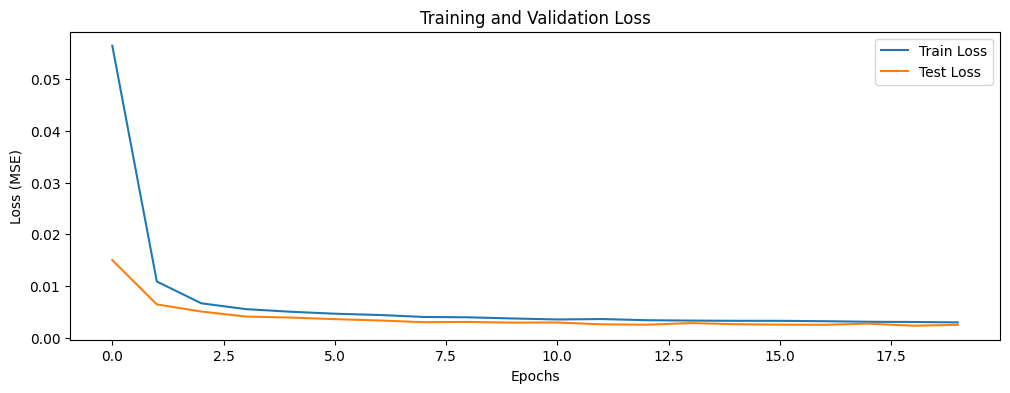

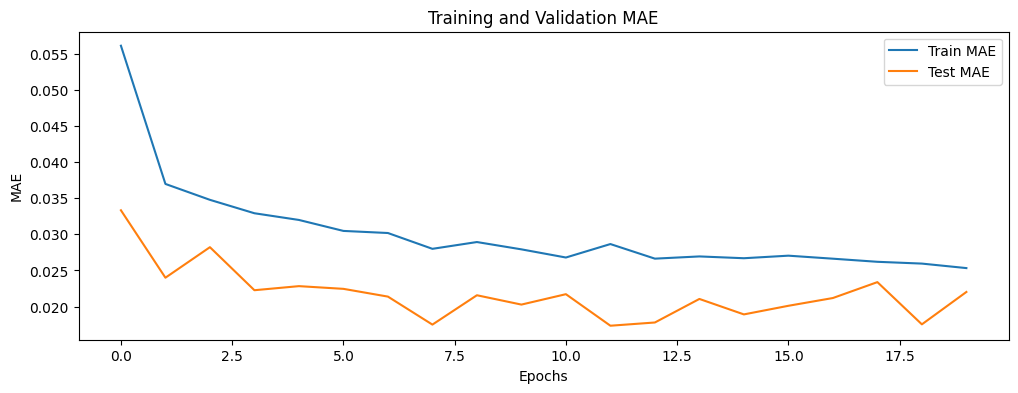

In [ ]:
# Plot training & validation loss over epochs
plt.figure(figsize=(12, 4))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Test Loss')
plt.title("Training and Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss (MSE)")
plt.legend()
plt.show()

# Plot training & validation MAE over epochs
plt.figure(figsize=(12, 4))
plt.plot(history.history['mae'], label='Train MAE')
plt.plot(history.history['val_mae'], label='Test MAE')
plt.title("Training and Validation MAE")
plt.xlabel("Epochs")
plt.ylabel("MAE")
plt.legend()
plt.show()